# Summary

#### Creating a function 'show_neighbours' which takes a product code from a dataset and returns the image of the product along with images of the 4 most visually similar products in the dataset. This invlolves:
    - Preprocessing images by making all images a square
    - Converting the image into a format expected by the VGG19 model
    - Using VGG19 to get vector representations (features) of each image
    - Calculate similarity of images by looking at how close their vectors are to each other Using KNN

In [1]:
import matplotlib.pyplot as plt
import skimage
import numpy as np
import pandas as pd
from tensorflow.keras.applications.vgg19 import VGG19
import os
from glob import glob
from sklearn.neighbors import NearestNeighbors
from PIL import ImageOps, Image as PilImage


In [2]:
def square_me(image_filepath, background = 'white'):
    """ 
    
    This function pads an image with a background colour to make the image a square
    keeping the old image at the center of the square
    
    """
    
    old_image = PilImage.open(image_filepath)
    
    # (width, height)
    old_size = old_image.size  

    #we will make the new image a square with a width & length 50 pixels bigger than the current length of pic
    new_size = max(old_size)+50

    #need to add delta_w//2 on each side of the picture to make image the desired width
    delta_w = new_size - old_size[0]

    #need to add delta_h//2 below and above the picture to make image the desired height
    delta_h = new_size - old_size[1]

    #padding = (lhs,top of pic,rhs,bottom of pic)
    padding = (delta_w//2, delta_h//2, delta_w//2, delta_h//2)
    
    new_im = ImageOps.expand(old_image, padding, fill=background)
    new_im = np.array(new_im)
    return new_im

In [3]:
def format_image(img:np.array)->np.array:
    '''Converts the image into the format that is expected by the VGG19 model'''
    resized_img = skimage.transform.resize(img, (224, 224, 3), mode='reflect', anti_aliasing=True)
    formated_img = resized_img.reshape(1, *resized_img.shape)
    return formated_img

### The original image before its converted into a square

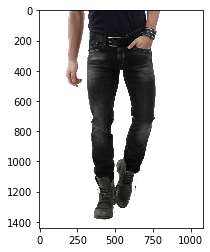

In [4]:
filename = glob('multi-output-classification/dataset/black_jeans/*.jpg')[2]
a = plt.imread(filename)
plt.imshow(a)

### The image after its converted into a square

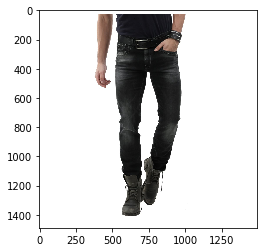

In [5]:
plt.imshow(square_me(filename))

### Use VGG19 model to get features (vector representation) for each image

In [6]:
model = VGG19(include_top=False, weights='imagenet', input_tensor=None, input_shape=None, pooling='max', classes=1000)

Instructions for updating:
Colocations handled automatically by placer.


### Make dataset with file name, unique product identifier, features etc

In [39]:
data = (pd.DataFrame({'filename':glob('multi-output-classification/dataset/*/*.jpg')})
        .sample(1500)
        
        #high level category the product belongs to i.e blacck_jeans
        .assign(category = lambda x: x['filename'].apply(lambda filename: filename.split('/')[2]))
    
        
        #final np array of image after preprocessing
        .assign(image_array = lambda x: x['filename'].apply(lambda filename: format_image(square_me(filename))))
        
        #get the feature set of each image
        .assign(model_prediction = lambda x: x['image_array'].apply(model.predict))
        .assign(features = lambda x: x['model_prediction'].apply(lambda x: x.ravel()))
        
        
        .reset_index()

       )

In [41]:
#give a unique code to each product in the dataset
data['product_code'] = pd.Series(range(1500)).astype('str')

In [42]:
data.head()

,index,filename,category,image_array,model_prediction,features,product_code
0,624,multi-output-classification/dataset/red_dress/...,red_dress,"[[[[1. 1. 1.], [1. 1. 1.], [1. 1. 1.], [1. 1. ...","[[2.5838203, 0.0, 0.42298386, 0.20760058, 1.06...","[2.5838203, 0.0, 0.42298386, 0.20760058, 1.069...",0
1,1374,multi-output-classification/dataset/red_shirt/...,red_shirt,"[[[[1. 1. 1.], [1. 1. 1.], [1. 1. 1.], [1. 1. ...","[[2.3105006, 0.0, 0.4590274, 0.19362497, 1.888...","[2.3105006, 0.0, 0.4590274, 0.19362497, 1.8881...",1
2,97,multi-output-classification/dataset/black_shoe...,black_shoes,"[[[[1. 1. 1.], [1. 1. 1.], [1. 1. 1.], [1. 1. ...","[[2.1574695, 0.0, 0.35587177, 0.575474, 0.8742...","[2.1574695, 0.0, 0.35587177, 0.575474, 0.87429...",2
3,1744,multi-output-classification/dataset/black_jean...,black_jeans,"[[[[1. 1. 1.], [1. 1. 1.], [1. 1. 1.], [1. 1. ...","[[1.3167963, 0.0, 0.55212414, 0.0, 1.0920782, ...","[1.3167963, 0.0, 0.55212414, 0.0, 1.0920782, 0...",3
4,43,multi-output-classification/dataset/black_shoe...,black_shoes,"[[[[1. 1. 1.], [1. 1. 1.], [1. 1. 1.], [1. 1. ...","[[1.2193584, 0.0, 0.32982025, 0.36674815, 1.00...","[1.2193584, 0.0, 0.32982025, 0.36674815, 1.007...",4


In [43]:
features = list(data['features'].values)
filenames = data['filename']
nbrs = NearestNeighbors(n_neighbors=5, algorithm = 'kd_tree').fit(features)
distances, indices = nbrs.kneighbors(features)

In [44]:
def show_neighbours(product_code, indices = indices, data=data):
    """
    This function takes a product_code and returns the image of the product along with images of similar products
    product_code : unique product identifier in dataset
    """
    #get index of product_code
    idx = data[data['product_code']==product_code].index.item()
    #get list of neighbours (index for eachc neighbour) for material
    
    neighbors = indices[idx]
    fig, axes = plt.subplots(1,5)
    fig.set_size_inches(20,20)
    #for i, neighbour in enumerate(neighbors):
    for ax, neighbour in zip(axes,neighbors):
        #image = square_me(plt.imread(filenames[neighbour]))
        image = square_me(filenames[neighbour])
        
        #plt.figure(i)
        ax.imshow(image)
        ax.axis('off')
    axes[0].set_title('product_code - '+ product_code)
    plt.show()
    #modify this to return a list of paths
    #add a template to template folder, pass this list to a HTML page, 
    #for each element in the list it could create a square with a picture

## Products the function worked well for

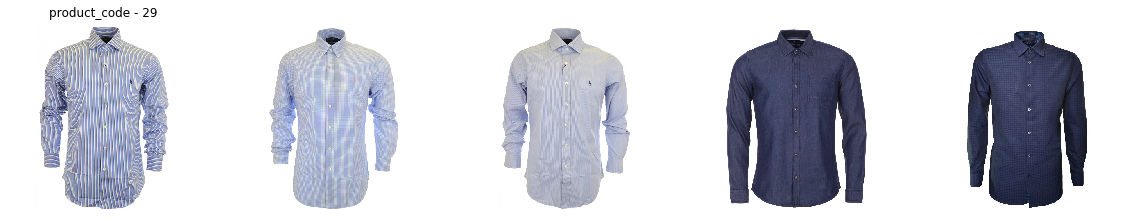

In [78]:
show_neighbours(product_code= '29')

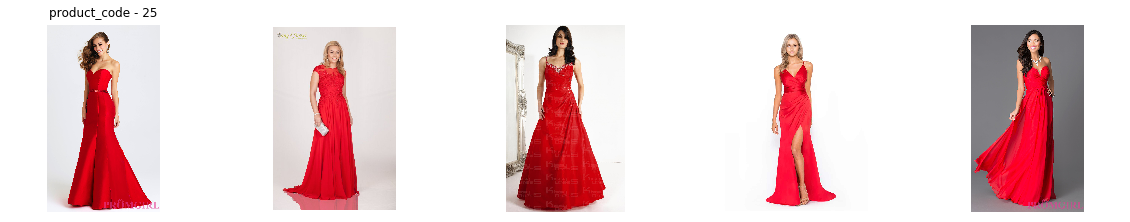

In [74]:
show_neighbours(product_code= '25')

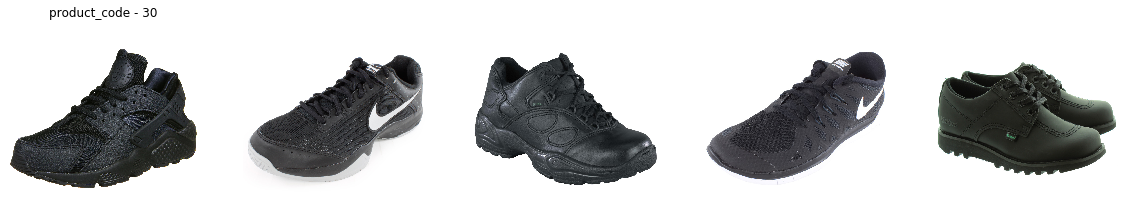

In [79]:
show_neighbours(product_code= '30')

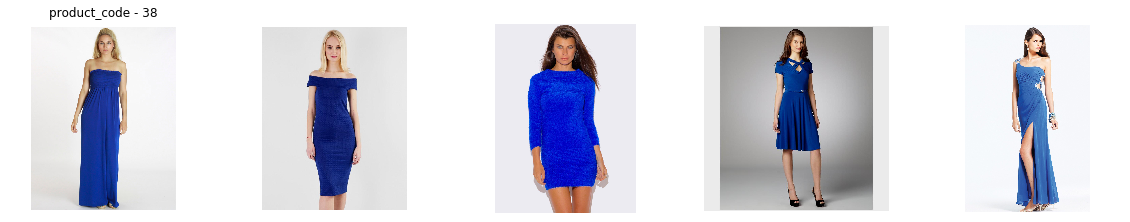

In [87]:
show_neighbours(product_code= '38')

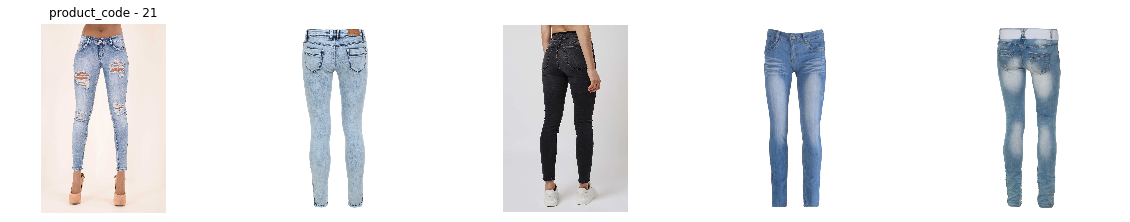

In [68]:
show_neighbours(product_code= '21')

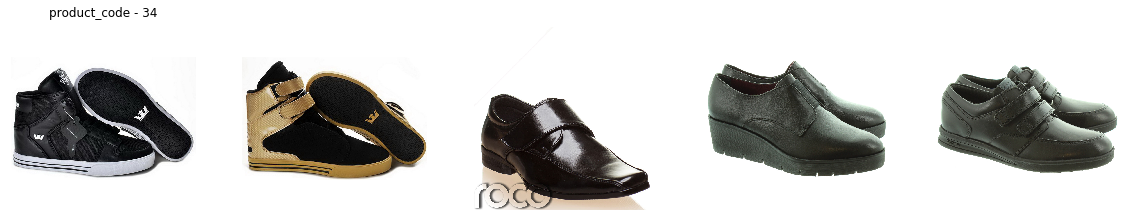

In [83]:
show_neighbours(product_code='34')

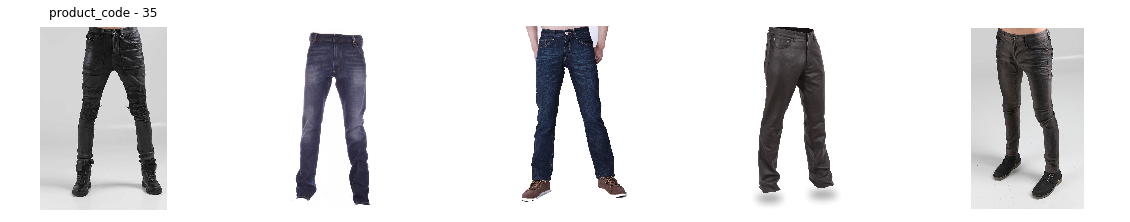

In [88]:
show_neighbours(product_code= '35')

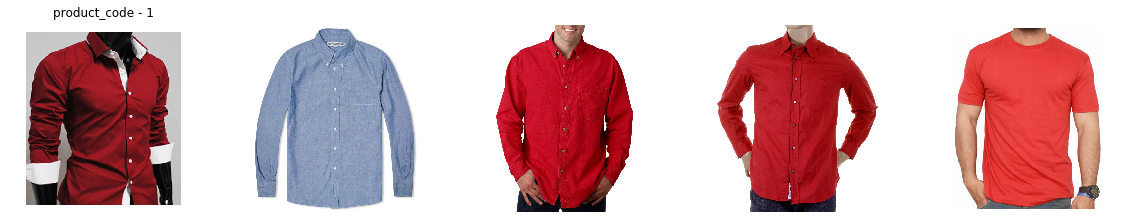

In [92]:
show_neighbours(product_code= '1')